Image Segmentation using Region Growing Algorithm


In [78]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2gray,label2rgb
from PIL import Image
import random
import numpy as np
from sklearn.metrics import jaccard_score


In [79]:
class RegGrowing: #Region growing algorithm class
    def __init__(self, thresh, num_seeds):
        self.num_seeds = num_seeds
        self.thresh = thresh
        self.adjacents = [pixel(-1,0),pixel(1,0),pixel(0,-1),pixel(0,1)]#Marking the four connected neighborhood    
    def generateSeeds(self, length, height): #Generate seeds randomly
        gen = zip(random.sample(range(0,length),self.num_seeds),
                   random.sample(range(0,height),self.num_seeds))
        return [pixel(x,y) for x,y in gen]    
    def fit(self, img):     #Create segment mask
        try:
            x,y = img.shape
        except ValueError:
            img = rgb2gray(img)  #Convert image to grayscale.
            x,y = img.shape
        self.img = img         #Create empty segmented image
        seg = np.ones(img.shape)
        low_bound = pixel(0,0)   #Creating bounds
        high_bound = pixel(x,y)
        seeds = self.generateSeeds(x,y)    #Stack of all seeds present
        while(len(seeds)):   #Run while stack is not empty
            curr = seeds.pop()
            seg[curr.x,curr.y] = 0
            #Checking all the neighbours
            for adj in self.adjacents:
                neigh = curr + adj
                #Checking the bounds
                if neigh<low_bound or neigh>high_bound:
                    continue
                #Add to stack, if it agrees with the condition.
                if self.criteria(curr, neigh) and seg[neigh.x,neigh.y] == 1:
                    seeds.append(neigh)
        return seg
                    
    def criteria(self, p1, p2): #Condition for growth
        return abs(self.img[p1.x,p1.y]-self.img[p2.x,p2.y]) < self.thresh

class pixel:     #Pixel objects to easily perform additions  
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __add__(self,other):
        return pixel(self.x+other.x, self.y+other.y)  
    def __str__(self):
        return "({},{})".format(self.x,self.y)
    def __lt__(self, other):        #Condition define only for bound checks
        return ((self.x<=other.x) or (self.y<=other.y))

(321, 481)

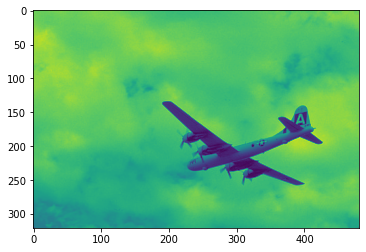

In [80]:
#from skimage.color import rgb2gray,label2rgb
#Function to convert rgb to grayscale
def Rgb2gray(rgb):
    #RGB to Grayscale
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
#Reading the image file
img=cv2.imread('image.jpg')
img = Rgb2gray(img) # Converting image from rgb to grayscale
plt.imshow(img) #Showing the grayscale image
img.shape

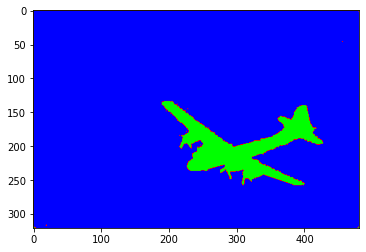

In [81]:
seg_img = RegGrowing(6,10).fit(img)  #Calling the Region Growing Function  
plt.imshow(seg_img, cmap='brg')      #Printing the Segmented output

Image Segmentation using Watershed Algorithm


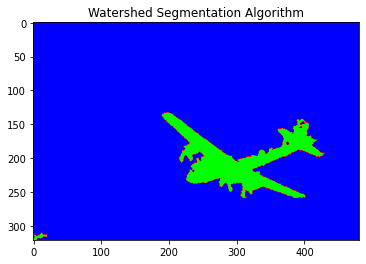

In [82]:
from collections import deque
img = cv2.imread("image.jpg") #Reading the image
img = np.array(img, dtype=np.int64)
gray_img = cv2.imread("image.jpg", 0) #Image to gray
gray_img = np.array(gray_img, dtype=np.int64)
dim = img.shape # image dimensions
if len(dim) <= 2:
    dim = (dim[0], dim[1], 1)

def assign_neighbour(img, intensity, region, neighbours, x, y):
    Dict = {} #Creating a dictionary for neighbours
    for i, j in neighbours: 
      # Continue if out of bounds
        if (                             
            x + i < 0
            or x + i >= dim[0]
            or y + j < 0
            or y + j >= dim[1]
            or region[x + i, y + j] == 0
        ):
            continue
            #Assign 1 if not in dictionary
        if Dict.get(region[x + i][y + j]) == None:
            Dict[region[x + i][y + j]] = 1
        else:
          #Increment if present in dictionary
            Dict[region[x + i][y + j]] += 1

    List = [] #Creating a list
    for key, value in Dict.items():
        List.append((value, key)) #Appending the list
    List.sort()

    if len(List) == 0:
        return -1
    return List[-1][1]


region = np.zeros(gray_img.shape)
region_count = 0

intensities = []
for i in range(dim[0]):
    for j in range(dim[1]):
   # Append the tuple (pixel_intensity, xy-coord) to the end of the list
        intensities.append((gray_img[i][j], i, j))
intensities.sort()

region_count = 0

neighbours = np.array(
    [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]
)
# Get the pixel intensity and the x,y coordinates
for intensity, x, y in intensities:
    neighbour_region = assign_neighbour(gray_img, intensity, region, neighbours, x, y)
    if neighbour_region >= 0:
        region[x, y] = neighbour_region
    else:
        region_count += 1
        region[x, y] = region_count
seg_img_ws = region.copy()

# Assign region number to watershed accordingly at pixel (x, y) in segmented image
threshold = 550
seg_img_ws[region < threshold] = 1
seg_img_ws[region >= threshold] = 0
seg_img_ws[region == 0] = 0
watershed = seg_img_ws.copy()
#plt.imshow(seg_img_ws, cmap="gray", vmin=0, vmax=1)
#To plot the image
plt.imshow(seg_img_ws, cmap="brg", vmin=0, vmax=1)
plt.title("Watershed Segmentation Algorithm")
plt.show()

Segmentation using K means Algorithm

In [94]:
np.random.seed(40)
def euclidean_distance(x1, x2): #Function to calculate the Euclidiean Distance
    return np.sqrt(np.sum((x1 - x2)**2))
class KMeans():
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps #indices list for each cluster
        self.clusters = [[] for _ in range(self.K)] #Centres for each cluster
        self.centroids = []
    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape        
        # initialization
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]
        # Optimizing the clusters
        for _ in range(self.max_iters):
            #Creating Clusters
            self.clusters = self._create_clusters(self.centroids)
            if self.plot_steps:
                self.plot()
            #Calculating new centroids
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            # Checking for convergence
            if self._is_converged(centroids_old, self.centroids):
                break
            if self.plot_steps:
                self.plot()
        # Classify samples by their cluster's indices
        return self._get_cluster_labels(self.clusters)
    def _get_cluster_labels(self, clusters):
        #Samples will get their cluster labels
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels
    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    def _closest_centroid(self, sample, centroids):
        #Get distance of the sample to each centroid by euclidean distance
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances) #get the closest centre
        return closest_index
    def _get_centroids(self, clusters): # assigning mean value of clusters to centres
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids
    def _is_converged(self, centroids_old, centroids): #if the centres converge
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0
    def plot(self): #Plotting figure
        fig, ax = plt.subplots(figsize=(12, 8))
        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)
        for point in self.centroids:
            ax.scatter(*point, marker="x", color='black', linewidth=2)
        plt.show()
    def cent(self):
        return self.centroids

In [95]:
image = cv2.imread('image.jpg') #Reading the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
 #calling the k means function for 2 clusters
k = KMeans(K=2, max_iters=100)   
y_pred = k.predict(pixel_values) 
k.cent()
centers = np.uint8(k.cent())
y_pred = y_pred.astype(int)
labels = y_pred.flatten()
segmented_image = centers[labels.flatten()] #Getting the segmented image
segmented_image = segmented_image.reshape(image.shape) #Reshaping like the image given

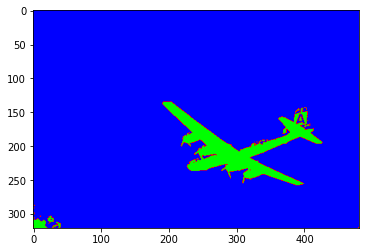

In [96]:
segmented_image=rgb2gray(segmented_image) #Converting to the segmented image to grayscale
#Changing pixels with thresholding
for i in range(segmented_image.shape[0]):  
  for j in range(segmented_image.shape[1]):
    if segmented_image[i][j] < 0.2:       
      segmented_image[i][j]=1
    else:
      segmented_image[i][j] = 0
#Showing the image      
plt.imshow(segmented_image, cmap='brg')

In [97]:
gt=cv2.imread('im2gt.png', 0)

for i in range(gt.shape[0]):
  for j in range(gt.shape[1]):
    if gt[i][j] <= 30:
      gt[i][j]=0
    else:
      gt[i][j] = 1
gt.shape      

(321, 481)

In [98]:
def jaccard_sim_index(img1, img2):
  intersect=img1.astype(np.bool) & img2.astype(np.bool)
  union=img1.astype(np.bool) | img2.astype(np.bool)
  return sum(intersect)/sum(union)

In [99]:
jsi_rg=jaccard_sim_index(gt.flatten(),seg_img.flatten())
jsi_ws=jaccard_sim_index(gt.flatten(),seg_img_ws.flatten())
jsi_kmean=jaccard_sim_index(gt.flatten(),segmented_image.flatten())
print(jsi_rg,jsi_ws,jsi_kmean)

0.8530095822867243 0.8570041743520047 0.8103625875566544


In [100]:
print("Jaccard Similarity index:")
print("Region Growth Algorithm:", jsi_rg)
print("Watershed Algorithm:", jsi_ws)
print("K means Algorithm:", jsi_kmean)


Jaccard Similarity index:
Region Growth Algorithm: 0.8530095822867243
Watershed Algorithm: 0.8570041743520047
K means Algorithm: 0.8103625875566544


According to the Jaccard Similarity Index, Watershed algorithm is performing better.
